# ML Pipeline for Time-Series Forecasting and Anomaly Detection with SSMs

In [1]:
import numpy as np
import scipy
import os
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split
import logging
import itertools
import matplotlib.pyplot as plt
import luminol
from luminol import anomaly_detector

In [2]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P),
                        (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

In [3]:
class ToxicityForecaster:
    
    DATA_PATH = "timeseries.csv"
    
    def __init__(self, ts, F=None, B=None, H=None, Q=None, R=None, P=None):
        self._init_logger()
        self.timeSeries = np.asarray(ts)
        self.kalman = KalmanFilter(F=F, B=B, H=H, Q=Q, R=R, P=P)
        
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
        
    def setKalmanParams(self, F=None, B=None, H=None, Q=None, R=None, P=None):
        self.kalman = KalmanFilter(F=F, B=B, H=H, Q=Q, R=R, P=P)

    def predict(self):
        self._logger.info('>>> Starting Latent State Prediction')
        observed, hidden = [], []
        for z in self.timeSeries:
            x = self.kalman.predict()
            hidden.append(x)
            observed.append(np.dot(self.kalman.H, x)[0])
            self.kalman.update(z)
        self._logger.info('>>> Completed Latent State Prediction')
        return observed, hidden
    
    def forecast(self, n_steps=50):
        observed, _ = self.predict()
        if not observed:
            return [], []
        forecasted = []
        self._logger.info('>>> Starting Forecasting')
        for i in range(n_steps):
            x = self.kalman.predict()
            z = np.dot(self.kalman.H, x)[0]
            forecasted.append(z)
            self.kalman.update(z)
        self._logger.info('>>> Completed Forecasting')
        return observed, forecasted

In [4]:
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)
x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2) + np.random.normal(0, 2, 100)

In [5]:
forecaster = ToxicityForecaster(measurements, F=F, H=H, Q=Q, R=R)
history, forecasted = forecaster.forecast()

2019-04-10 00:33:37,451 __main__     INFO     >>> Starting Latent State Prediction
2019-04-10 00:33:37,458 __main__     INFO     >>> Completed Latent State Prediction
2019-04-10 00:33:37,459 __main__     INFO     >>> Starting Forecasting
2019-04-10 00:33:37,463 __main__     INFO     >>> Completed Forecasting


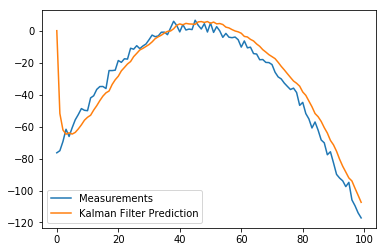

In [6]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(history)), np.array(history), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

### Look ahead time-series forecasting with SSMs

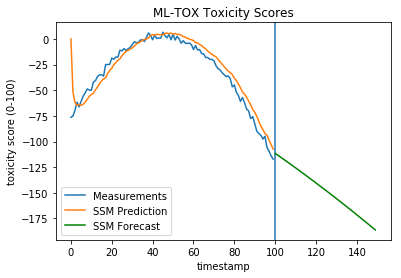

In [7]:
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.axvline(x=len(history))
plt.plot(range(len(history)), np.array(history), label = 'SSM Prediction')
plt.plot(range(len(history),len(history)+len(forecasted)), 
         np.array(forecasted), label = 'SSM Forecast', color='g')
plt.legend()
plt.title('ML-TOX Toxicity Scores')
plt.xlabel('timestamp')
plt.ylabel('toxicity score (0-100)')
plt.show()

### Anomaly detection for time-series using LinkedIn luminol

In [ ]:
history.extend(forecasted)
history = np.asarray(history).flatten()
indices = np.array(range(len(history)))
timeseries = pd.DataFrame({'timestamp': indices, 'toxicity': history})
timeseries.to_csv(ToxicityForecaster.DATA_PATH)
detector = anomaly_detector.AnomalyDetector(ToxicityForecaster.DATA_PATH)
anomalies = detector.get_anomalies()
for anomaly in anomalies:
    print(anomaly)